Diversity in the Workplace
==============

<ol><li>In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.</li>
    <ul><li>Individual Contributors (IC) - they don't manage anyone</li> 
        <li>Middle Managers (MM) - they are the direct bosses of IC</li> <li>Directors (D) - they are the direct bosses of MM</li>
        <li>VP - D direct bosses</li>
        <li>Executives (E) - VP direct bosses</li>
        <li>CEO - The direct boss of E.</li>
    </ul>
<li>How many people each employee manages? You should have a table with employee ids and the number of people managed. Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.</li>
<li>Build a model to predict the salary of each employee.</li>
<li>Describe the main factors impacting employee salaries. Do you think the company has been treating its employees fairly? Do you see any bias? What are the next steps you would suggest to the Head of HR</li>
</ol>

In [21]:
import numpy as np
import scipy as sc
import scipy.stats as st
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [22]:
emp_headers=['emp_id', 'signing_bonus', 'base_salary', 'education', 'gender', 'experience']
emp_comp_hyerarchy=['emp_id', 'boss_id', 'dept']

df_emp = pd.read_csv('HR/employee.csv', names=emp_headers, skiprows = 1)

df_company = pd.read_csv('HR/company_hierarchy.csv',names = emp_comp_hyerarchy ,skiprows = 1)

print(df_company.head(5))
print(df_emp.head(5))

   emp_id   boss_id   dept
0   46456  175361.0  sales
1  104708   29733.0     HR
2  120853   41991.0  sales
3  142630  171266.0     HR
4   72711  198240.0  sales
   emp_id  signing_bonus  base_salary    education gender  experience
0  138719              0     273000.0       Master      M           2
1    3192              0     301000.0     Bachelor      F           1
2  114657              0     261000.0       Master      F           2
3   29039              0      86000.0  High_School      F           4
4  118607              0     126000.0     Bachelor      F           3


In [47]:
df = pd.merge(df_emp,
              df_company[['emp_id','boss_id', 'dept']],
              on='emp_id')

encode_education = {'education':{'High_School': 0, 'Bachelor': 1, 'Master': 2, 'PhD': 3}}
encode_level = {'level': {'CEO': 0, 'Exec': 1, 'VP': 2, 'Director': 3, 'MM': 4, 'IC': 5}}

df.replace(encode_education, inplace=True)
df

,emp_id,signing_bonus,base_salary,education,gender,experience,boss_id,dept
0,138719,0,273000.0,2,M,2,43602.0,engineering
1,3192,0,301000.0,1,F,1,87847.0,sales
2,114657,0,261000.0,2,F,2,180854.0,sales
3,29039,0,86000.0,0,F,4,88370.0,HR
4,118607,0,126000.0,1,F,3,23565.0,sales
5,91334,0,221000.0,3,F,2,62990.0,sales
6,101901,1,194000.0,3,M,12,7558.0,engineering
7,171111,1,119000.0,2,F,1,30468.0,engineering
8,23443,1,217000.0,3,M,8,130585.0,sales
9,24195,0,230000.0,2,M,4,1050.0,engineering


In [50]:
df['level'] = 10
df['people_under'] = 0

df_structure = df[['emp_id', 'boss_id']]
df_structure
print(df_structure.head(10))
    
G = nx.DiGraph()
G.add_nodes_from(df[['emp_id']])
for index, row in df[['emp_id', 'boss_id']].iterrows():
    G.add_edge(row['boss_id'], row['emp_id'])

print('number of nodes: %d' % G.number_of_nodes())
print('number of edges: %d' % G.number_of_edges())

def get_levels(G, CEO):
    a = df.loc[df['emp_id'] == CEO]['level'].index.values[0]
    df.loc[a,'level'] = 0 
    execs=[]
    vps = []
    directors = []
    mms = []
    ics = []
    
    for ex in G.neighbors(CEO):
        execs.append(int(ex))
        b = df.loc[df['emp_id'] == int(ex)]['level'].index.values[0]
        df.loc[b,'level'] = 1
    
    for ex in execs:
        for vp in G.neighbors(ex):
            if vp in execs:
                continue
            else:
                vps.append(int(vp))
                c = df.loc[df['emp_id'] == int(vp)]['level'].index.values[0]
                df.loc[c,'level'] = 2
            
    for vp in vps:
        for director in G.neighbors(vp):
            if director in vps:
                continue
            else:
                directors.append(int(director))
                d = df.loc[df['emp_id'] == int(director)]['level'].index.values[0]
                df.loc[d,'level'] = 3
    
    for director in directors:
        for mm in G.neighbors(director):
            if mm in directors:
                continue
            else:
                mms.append(int(mm))
                e = df.loc[df['emp_id'] == int(mm)]['level'].index.values[0]
                df.loc[e,'level'] = 4
    
    for mm in mms:
        for ic in G.neighbors(mm):
            if ic in mms:
                continue
            else:
                ics.append(int(ic))
                f = df.loc[df['emp_id'] == int(ic)]['level'].index.values[0]
                df.loc[f,'level'] = 5        
    
ceo = 61554
#df.loc[df['emp_id'] == 61554]['emp_id'].values[0]
#ceo = df.loc[df['emp_id'] == 61554]['emp_id'].values[0]

get_levels(G, ceo)


   emp_id   boss_id
0  138719   43602.0
1    3192   87847.0
2  114657  180854.0
3   29039   88370.0
4  118607   23565.0
5   91334   62990.0
6  101901    7558.0
7  171111   30468.0
8   23443  130585.0
9   24195    1050.0
number of nodes: 10002
number of edges: 10000


Departmet of eng min:  60000.0
Departmet of eng max:  650000.0
Departmet of eng average:  243524.85163204747
Departmet of eng standard deviation:  87577.44377752223
Departmet of eng min:  60000.0
Departmet of eng max:  500000.0
Departmet of eng average:  84560.21251475796
Departmet of eng standard deviation:  24128.218221499425


{'whiskers': [<matplotlib.lines.Line2D at 0x1146ce588>,
 'caps': [<matplotlib.lines.Line2D at 0x114738240>,
 'boxes': [<matplotlib.lines.Line2D at 0x1146ce828>],
 'medians': [<matplotlib.lines.Line2D at 0x1147385f8>],
 'fliers': [<matplotlib.lines.Line2D at 0x114738940>],
 'means': []}

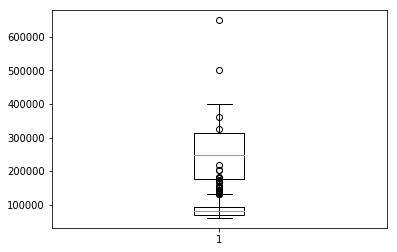

In [44]:
#Analysis of engineering data
df_dept_eng = df.loc[df['dept'] == 'engineering']
dept_eng_min = df_dept_eng["base_salary"].min()
dept_eng_max = df_dept_eng["base_salary"].max()
dept_eng_avg = df_dept_eng["base_salary"].mean()
dept_eng_std = df_dept_eng["base_salary"].std()
print('Departmet of eng min: ', dept_eng_min)
print('Departmet of eng max: ', dept_eng_max)
print('Departmet of eng average: ', dept_eng_avg)
print('Departmet of eng standard deviation: ', dept_eng_std)
plt.boxplot(df_dept_eng["base_salary"])

# df_dept_engineering
# df_dept_marketing
# df_dept_sales

Departmet of HR min:  60000.0
Departmet of HR max:  500000.0
Departmet of HR average:  84560.21251475796
Departmet of HR standard deviation:  24128.218221499425


{'whiskers': [<matplotlib.lines.Line2D at 0x1147eb3c8>,
 'caps': [<matplotlib.lines.Line2D at 0x1147eba58>,
 'boxes': [<matplotlib.lines.Line2D at 0x1147e3f98>],
 'medians': [<matplotlib.lines.Line2D at 0x1147ebe80>],
 'fliers': [<matplotlib.lines.Line2D at 0x1147f6470>],
 'means': []}

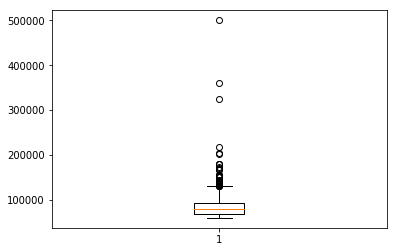

In [45]:
#Analysis of HR data
df_dept_HR = df.loc[df['dept'] == 'HR']
dept_HR_min = df_dept_HR["base_salary"].min()
dept_HR_max = df_dept_HR["base_salary"].max()
dept_HR_avg = df_dept_HR["base_salary"].mean()
dept_HR_std = df_dept_HR["base_salary"].std()
print('Departmet of HR min: ', dept_HR_min)
print('Departmet of HR max: ', dept_HR_max)
print('Departmet of HR average: ', dept_HR_avg)
print('Departmet of HR standard deviation: ', dept_HR_std)
plt.boxplot(df_dept_HR["base_salary"])

Departmet of HR min:  60000.0
Departmet of HR max:  550000.0
Departmet of HR average:  194342.03945540427
Departmet of HR standard deviation:  72636.17475166425


{'whiskers': [<matplotlib.lines.Line2D at 0x1148415c0>,
 'caps': [<matplotlib.lines.Line2D at 0x114841c50>,
 'boxes': [<matplotlib.lines.Line2D at 0x1148411d0>],
 'medians': [<matplotlib.lines.Line2D at 0x11484b320>],
 'fliers': [<matplotlib.lines.Line2D at 0x11484b668>],
 'means': []}

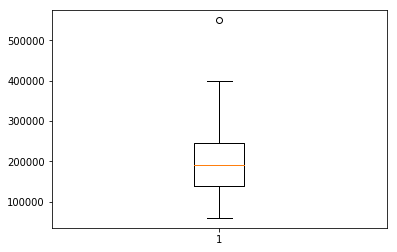

In [46]:
#Analysis of sales data
df_dept_sales = df.loc[df['dept'] == 'sales']
dept_sales_min = df_dept_sales["base_salary"].min()
dept_sales_max = df_dept_sales["base_salary"].max()
dept_sales_avg = df_dept_sales["base_salary"].mean()
dept_sales_std = df_dept_sales["base_salary"].std()
print('Departmet of sales min: ', dept_sales_min)
print('Departmet of sales max: ', dept_sales_max)
print('Departmet of sales average: ', dept_sales_avg)
print('Departmet of sales standard deviation: ', dept_sales_std)
plt.boxplot(df_dept_sales["base_salary"])

Departmet of marketing min:  60000.0
Departmet of marketing max:  550000.0
Departmet of marketing average:  194623.3830845771
Departmet of marketing standard deviation:  75975.97240427414


{'whiskers': [<matplotlib.lines.Line2D at 0x114a25a90>,
 'caps': [<matplotlib.lines.Line2D at 0x114a25eb8>,
 'boxes': [<matplotlib.lines.Line2D at 0x114a256a0>],
 'medians': [<matplotlib.lines.Line2D at 0x114a2c7f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x114a2cb38>],
 'means': []}

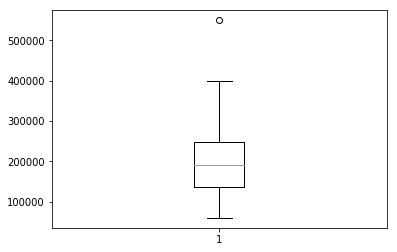

In [48]:
#Analysis of marketing data
df_dept_mark = df.loc[df['dept'] == 'marketing']
dept_mark_min = df_dept_mark["base_salary"].min()
dept_mark_max = df_dept_mark["base_salary"].max()
dept_mark_avg = df_dept_mark["base_salary"].mean()
dept_mark_std = df_dept_mark["base_salary"].std()
print('Departmet of marketing min: ', dept_mark_min)
print('Departmet of marketing max: ', dept_mark_max)
print('Departmet of marketing average: ', dept_mark_avg)
print('Departmet of marketing standard deviation: ', dept_mark_std)
plt.boxplot(df_dept_mark["base_salary"])

In [51]:
def getNumOfManagedEmployees(emp_id, graph): 
    if len(list(G.successors(emp_id))) == 0:
        return 0
    totalNum = 0
    for employee in list(G.successors(emp_id)):
       totalNum += getNumOfManagedEmployees(employee, graph) + 1
    return totalNum

for index, row in df[['emp_id']].iterrows():
    res = getNumOfManagedEmployees(row['emp_id'], G)
    a = df.loc[df['emp_id'] == row['emp_id']]['people_under'].index.values[0]
    df.loc[a,'people_under'] = res
    

In [61]:
df = pd.get_dummies(df)
#print(df.head(20))
#labels are the values we want to predict
prediction_label = np.array(df['base_salary'])
#remove the labels from the feature
prediction_data =  df.drop(['base_salary', 'boss_id', 'emp_id'], axis = 1)
#print(prediction_data)
#save the feature names for later use
data_features = list(prediction_data)
#convert to numpy array
prediction_data = np.array(prediction_data)
prediction_data

array([[0, 2, 2, ..., 1, 0, 0],
       [0, 1, 1, ..., 0, 0, 1],
       [0, 2, 2, ..., 0, 0, 1],
       ...,
       [1, 1, 4, ..., 0, 0, 1],
       [0, 3, 4, ..., 0, 1, 0],
       [0, 2, 1, ..., 0, 0, 1]])

In [62]:
#Divide the data into training and testing datasets randomly 
train_feature, test_feature, train_label, test_label = train_test_split(prediction_data, 
                                                                        prediction_label, 
                                                                        test_size=0.25, 
                                                                        random_state = 42)
print('Training Data Shape', train_feature.shape)
print('Training Label Shape', train_label.shape)
print('Test Data Shape', test_feature.shape)
print('Test Lable Shape', test_label.shape)

Training Data Shape (7500, 12)
Training Label Shape (7500,)
Test Data Shape (2500, 12)
Test Lable Shape (2500,)


In [63]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
#Train the model on training data
rf.fit(train_feature, train_label)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [74]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_feature)
# Calculate the absolute errors
errors = abs(predictions - test_label)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'Dollars.')

Mean Absolute Error: 73082.45 Dollars.


In [65]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_label)
print(mape)

[ 61.83022214 109.45488667  35.4831167  ...  12.90952207 134.25527196
 148.97578947]


In [66]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(data_features, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: dept_HR              Importance: 0.58
Variable: dept_engineering     Importance: 0.12
Variable: experience           Importance: 0.1
Variable: people_under         Importance: 0.07
Variable: education            Importance: 0.05
Variable: signing_bonus        Importance: 0.03
Variable: level                Importance: 0.01
Variable: gender_F             Importance: 0.01
Variable: gender_M             Importance: 0.01
Variable: dept_marketing       Importance: 0.01
Variable: dept_sales           Importance: 0.01
Variable: dept_CEO             Importance: 0.0


In [68]:
'''
Dropping some of the one hot encoding and reducing the features wil give us the importance of the other labels
'''
#labels are the values we want to predict
prediction_label = np.array(df['base_salary'])
#remove the labels from the feature
prediction_data =  df.drop(['base_salary', 
                            'boss_id', 
                            'emp_id', 
                            'dept_HR', 
                            'dept_engineering', 
                            'dept_marketing',
                            'dept_sales', 
                            'dept_CEO'], axis = 1)
#print(prediction_data)
#save the feature names for later use
data_features = list(prediction_data)
#convert to numpy array
prediction_data = np.array(prediction_data)
prediction_data

array([[0, 2, 2, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 1, 0],
       [0, 2, 2, ..., 0, 1, 0],
       ...,
       [1, 1, 4, ..., 0, 0, 1],
       [0, 3, 4, ..., 0, 0, 1],
       [0, 2, 1, ..., 0, 0, 1]])

In [69]:
#Divide the data into training and testing datasets randomly 
train_feature, test_feature, train_label, test_label = train_test_split(prediction_data, 
                                                                        prediction_label, 
                                                                        test_size=0.25, 
                                                                        random_state = 42)
print('Training Data Shape', train_feature.shape)
print('Training Label Shape', train_label.shape)
print('Test Data Shape', test_feature.shape)
print('Test Lable Shape', test_label.shape)

Training Data Shape (7500, 7)
Training Label Shape (7500,)
Test Data Shape (2500, 7)
Test Lable Shape (2500,)


In [70]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
#Train the model on training data
rf.fit(train_feature, train_label)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [75]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_feature)
# Calculate the absolute errors
errors = abs(predictions - test_label)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'Dollars.')

Mean Absolute Error: 73082.45 Dollars.


In [73]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_label)
print(mape)

[ 76.13631887 102.43295954  40.79240454 ...  97.1429796  128.39207126
 114.93403509]


In [72]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(data_features, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: experience           Importance: 0.33
Variable: people_under         Importance: 0.3
Variable: education            Importance: 0.15
Variable: signing_bonus        Importance: 0.06
Variable: gender_F             Importance: 0.06
Variable: gender_M             Importance: 0.06
Variable: level                Importance: 0.03
